In [1]:
import netCDF4
import numpy as np
import pandas as pd
import os
import xarray as xr
from fbprophet.utilities import regressor_coefficients
import pandas as pd
from fbprophet import Prophet
import seaborn as sns
import multiprocessing
multiprocessing.set_start_method("fork")

# CERES

In [2]:
ceres_1 = pd.read_parquet("../CERES_2022-11-09_25176/ceres.parquet.gzip")
ceres_2 = pd.read_parquet("../CERES_2022-11-09_25176/ceres1.parquet.gzip")


In [3]:
ceres = pd.concat([ceres_2,ceres_1])

In [4]:
lat_lon_weight = pd.read_csv("zone_weights_lou.txt")

In [5]:
ceres = ceres.query('lat > -66 & lat <66')

In [6]:
weights = []
for index, group in ceres.groupby(level="lat"):
    weight = lat_lon_weight[lat_lon_weight["lat"] ==index]["weight"].iloc[0]
    weights.append(weight)

In [7]:
i=0 
for index, group in ceres.groupby(level="lat"):
    ceres.loc[(slice(None), index,slice(None)),"weights"] = weights[i] 
    i+=1


In [8]:
TERMINATOR = True
ceres["albedo"] = ceres["toa_alb_all_mon"]*ceres["weights"]*(1/360.0)
data_agg_ceres = ceres.groupby(level="time").mean()
if TERMINATOR: 
    data_agg_ceres["albedo"]=(360*132/np.sum(weights))*data_agg_ceres["albedo"]
else:
    data_agg_ceres["albedo"]=(360*180)*data_agg_ceres["albedo"]

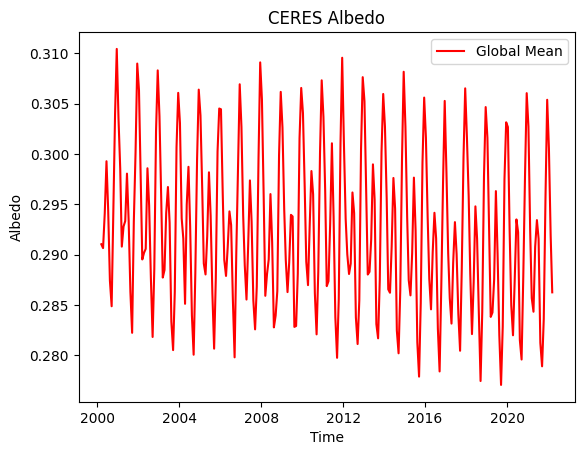

In [9]:
import matplotlib.pyplot as plt
sns.lineplot(data_agg_ceres["albedo"],label="Global Mean",c="red")
plt.ylabel("Albedo")
plt.xlabel("Time")
plt.title("CERES Albedo")
plt.savefig('plots/albedo.png')


### Basline Machine Learning Approach

In [10]:
ceres.reset_index(inplace=True)

In [11]:
to_drop_with_total = [col  for col in ceres.columns if "cld" in col or "lwp" in col or "iwp" in col]
to_drop_no_total = list(filter(lambda x:"total" not in x,to_drop_with_total))
# ceres.drop(to_drop,axis=1,inplace=True)
to_drop_no_total.extend(["weights",])

In [12]:
ceres.drop(to_drop_no_total,axis=1,inplace=True)

In [13]:
import datetime
ceres["time"]=ceres["time"].apply(lambda row: row.month)


In [14]:
ceres.rename({"time":"month"},inplace=True,axis=1)

In [15]:
ceres.drop(["albedo"],axis=1,inplace=True)

In [16]:
ceres.dropna(inplace=True)

In [17]:
from sklearn.model_selection import train_test_split
X = ceres.loc[:, ceres.columns!='toa_alb_all_mon']
y = ceres.loc[:, ceres.columns=='toa_alb_all_mon']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2)

In [18]:
from interpret.glassbox import ExplainableBoostingRegressor
ebm = ExplainableBoostingRegressor()
ebm.fit(X_train, y_train)

ExplainableBoostingRegressor()

In [19]:
prediction = ebm.predict(X_test)

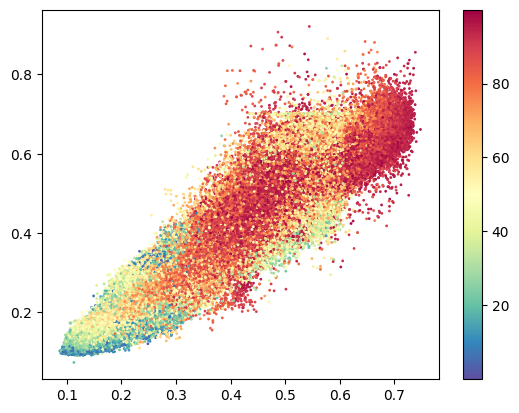

In [52]:
plt.scatter(x=prediction,
            y=y_test.values.flatten(),
            s=1,c=X_test["cldarea_total_mon"],
            cmap="Spectral_r")
plt.colorbar()

In [54]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(prediction,y_test.values.flatten())

0.07177179180085476

In [24]:
from interpret import show

ebm_global = ebm.explain_global()
show(ebm_global)

<!-- http://127.0.0.1:7001/6026638528/ -->

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from interpret.glassbox import ExplainableBoostingRegressor
rf = RandomForestRegressor(n_estimators=500,verbose=2)
rf.fit(X_train, y_train)

/var/folders/8_/qfq2f03j40x2lyrbnm67xqm40000gn/T/ipykernel_4604/2245634659.py:4: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 500


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min remaining:    0.0s


building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
